# Final Capstone

## Gene Expression database mining

### Part 1. Introduction and goals; data wrangling.

Can we detect cancer with a simple blood test?  Can we discover new treatment targets with expression arrays?  Over the last 25 years a great deal of research has been devoted to answering these questions. In this paper we explore and assess a gene expression dataset to discover what patterns are present and how they might be usefully interpreted.

This dataset is the 'TCGA - LUSC (Lung Cell Squamous Carcinoma)' Expression Profiling by Array Dataset and is publicly available at https://portal.gdc.cancer.gov/. The data is normalized by TPM (transcripts per kilobase million) to make it interpretable across the samples but needs further processing.

Lung cancer is one of the deadliest cancers in the world and LUSC is the one of the most common subtypes of lung cancer. The microarray measures the activity of genes in a sample by performing selective binding and measuring fluorescence of mRNA fragments (or gene 'transcripts': recall that DNA is transcribed into mRNA and released to the cytosome where it encounters ribosomes and is then translated into proteins). We expect to see both up- and down-regulation of genes in ways that differ between cancer and healthy samples.

The dataset consist of 551 patients. Every patient's array has 56,907 different transcripts. This dataset is imbalanced, with 49 patients diagnosed as healthy and the rest having cancer (n=502).  Each gene is labeled but is not annotated to describe its function; hence, a publically available database of gene annotations will be added in Section 2.  These annotations will be of great importance for selecting subsets of genes that are specific to lung cell activity, and whose functions can be analyzed in various ways to interpret the results from a biological standpoint as well as a purely analytic one. 

Goals: Add annotations to filter genes by specific activity in lung cells.  Find a subset of genes based on biological considerations, and evaluate their use in a model to predict normal vs. cancer based on differential expression.

-----------------------------------------------------------------------------------------

References
**PLoS Genet. 2011 Aug; 7(8): e1002207.
Published online 2011 Aug 11. doi: 10.1371/journal.pgen.1002207
PMCID: PMC3154954
PMID: 21852951
Variance of Gene Expression Identifies Altered Network Constraints in Neurological Disease

Implications of applied research for prognosis and therapy of breast cancer
M.F. Barginear, ... D.R. Budman, in 
Critical Reviews in Oncology/Hematology
, 2008  chapter 3.1 Microarray analysis

## Data import and cleanup

The dataset has mixed datatypes, uses a combination of delimiters and has headers that mask patient ID:

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('LUSCexpfile.csv', sep = ';') 
#print(df.head())

C:\Users\Owner\AppData\Local\Temp\ipykernel_43980\1890420037.py:5: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

First let's remove the patient identifiers, and temporarily replace them with just a number.

In [292]:
df.columns = np.arange(len(df.columns)) 

In [293]:
print(df.head())

        0            1    ...          550          551
0       NaN       normal  ...        tumor        tumor
1      A1BG  0.108403483  ...  0.067741511  0.017848088
2  A1BG-AS1  1.187325638  ...  0.394044479  0.187729763
3      A1CF  0.001370356  ...  0.004709856  0.003722766
4       A2M  459.7836081  ...   120.810731  57.23277815

[5 rows x 552 columns]


The data would look nicer transposed:

In [294]:
df2 = df.T
print(df2.head())

    0            1      ...  56906     56907
0     NaN         A1BG  ...  ZYXP1     ZZEF1
1  normal  0.108403483  ...    0.0  4.552543
2  normal  0.095187869  ...    0.0  5.626856
3  normal  0.097042537  ...    0.0  2.309259
4  normal   0.04302861  ...    0.0  5.302771

[5 rows x 56908 columns]


In [295]:
df2.loc[0, 0] = 'SampleType'  #quick fix to column header
print(df2.head())

        0            1      ...  56906     56907
0  SampleType         A1BG  ...  ZYXP1     ZZEF1
1      normal  0.108403483  ...    0.0  4.552543
2      normal  0.095187869  ...    0.0  5.626856
3      normal  0.097042537  ...    0.0  2.309259
4      normal   0.04302861  ...    0.0  5.302771

[5 rows x 56908 columns]


Fix the other column headers by removing the index numbers from earlier.

In [296]:
df2.columns = df2.iloc[0]

#remove first row from DataFrame
df2 = df2[1:]

#view updated DataFrame
print(df2.head())

0 SampleType         A1BG  ... ZYXP1     ZZEF1
1     normal  0.108403483  ...   0.0  4.552543
2     normal  0.095187869  ...   0.0  5.626856
3     normal  0.097042537  ...   0.0  2.309259
4     normal   0.04302861  ...   0.0  5.302771
5     normal  0.095016254  ...   0.0  5.399341

[5 rows x 56908 columns]


In [297]:
print(df2.dtypes)  

0
SampleType    object
A1BG          object
A1BG-AS1      object
A1CF          object
A2M           object
               ...  
ZYG11AP1      object
ZYG11B        object
ZYX           object
ZYXP1         object
ZZEF1         object
Length: 56908, dtype: object


This is a problem: ALL but the 'sampletype' column must be changed into floats otherwise it will create problems down the line.

### Fix data type problems:

In [298]:
df2['SampleType'] = df2['SampleType'].map({'normal': 0.0, 'tumor': 1.0}) #temporarily removing the string values
pd.options.display.max_columns = 5
print(df2.head(50))

0   SampleType         A1BG  ... ZYXP1     ZZEF1
1          0.0  0.108403483  ...   0.0  4.552543
2          0.0  0.095187869  ...   0.0  5.626856
3          0.0  0.097042537  ...   0.0  2.309259
4          0.0   0.04302861  ...   0.0  5.302771
5          0.0  0.095016254  ...   0.0  5.399341
6          0.0  0.184691931  ...   0.0  5.538256
7          0.0  0.049553602  ...   0.0  4.099797
8          0.0  0.084045631  ...   0.0   4.20028
9          0.0  0.055256044  ...   0.0  6.300417
10         0.0   0.11879959  ...   0.0  6.482868
11         0.0  0.233579579  ...   0.0  6.754923
12         0.0  0.074725214  ...   0.0  5.522444
13         0.0  0.088147982  ...   0.0  3.728021
14         0.0  0.082127798  ...   0.0  5.299801
15         0.0  0.092215664  ...   0.0  5.676879
16         0.0  0.194815279  ...   0.0  5.329231
17         0.0  0.123645772  ...   0.0  2.989586
18         0.0  0.079961586  ...   0.0  4.132045
19         0.0  0.050850568  ...   0.0  2.772167
20         0.0   0.1

Now convert the datatypes:

In [299]:
df3=df2.convert_dtypes()
print(df3.dtypes)

0
SampleType             Int64
A1BG          string[python]
A1BG-AS1      string[python]
A1CF          string[python]
A2M           string[python]
                   ...      
ZYG11AP1             Float64
ZYG11B               Float64
ZYX                  Float64
ZYXP1                Float64
ZZEF1                Float64
Length: 56908, dtype: object


Some of these didn't convert properly, so let's fix that.

In [300]:
df4=df3.astype(float)
print(df4.dtypes)

0
SampleType    float64
A1BG          float64
A1BG-AS1      float64
A1CF          float64
A2M           float64
               ...   
ZYG11AP1      float64
ZYG11B        float64
ZYX           float64
ZYXP1         float64
ZZEF1         float64
Length: 56908, dtype: object


This completes the first round of cleanup; more may be done as we proceed.

### Initial data exploration

The data should be separated into groups (normal and cancer) before running summary stats.  However--it's important to take a look at the data.  It was 'normalized', but how?  Expression data can vary by orders of magnitude, and it's conventional to take the log based 2 in order to arrive at data that's closer to normally distributed.  Did the owners of the dataset do this already or not?

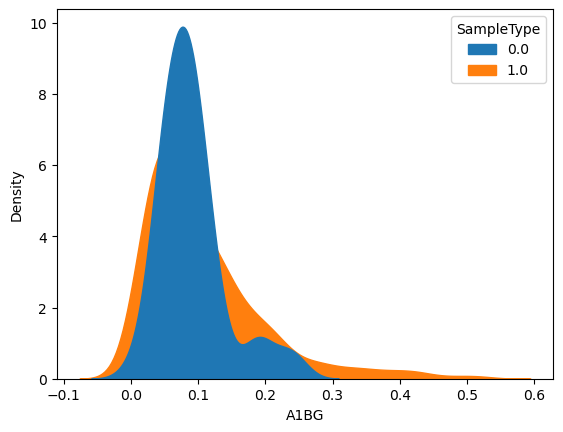

In [301]:
import seaborn as sns
# Here I could also plot a histogram but these are nicer...!
sns.kdeplot(data=df4, x='A1BG', hue="SampleType", fill=True, common_norm=False, alpha=1)  #just picked a random gene for illustration
plt.show()


Remember the kde will smooth things out, so we 'appear' to have negative values--but the overall variance doesn't *look* super large.  Let's be sure there aren't actual negative numbers in the data (or zeroes, which would be a clue they didn't do the log).

In [302]:
print(df4['A1BG'].min())

0.0


In [303]:
print(df4['A1BG'].sort_values())

252    0.000000
500    0.000000
432    0.004394
440    0.005298
447    0.007775
         ...   
386    0.425880
316    0.443253
215    0.477096
360    0.505444
424    0.518196
Name: A1BG, Length: 551, dtype: float64


So it looks like we should take the log.  Let's try another gene.

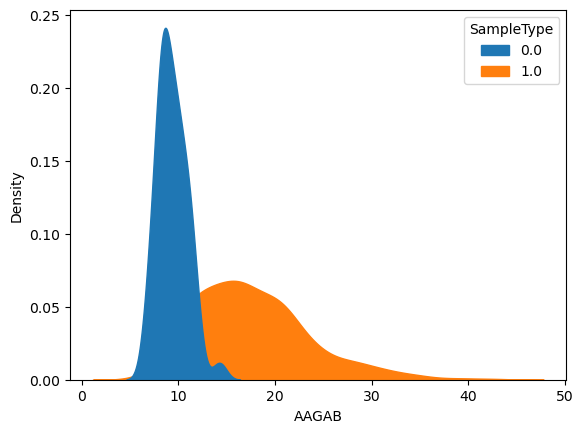

In [611]:
sns.kdeplot(data=df4, x='AAGAB', hue="SampleType", fill=True, common_norm=False, alpha=1)
plt.show()

It may be important to know how many genes are expressed at null as we proceed with the analysis:

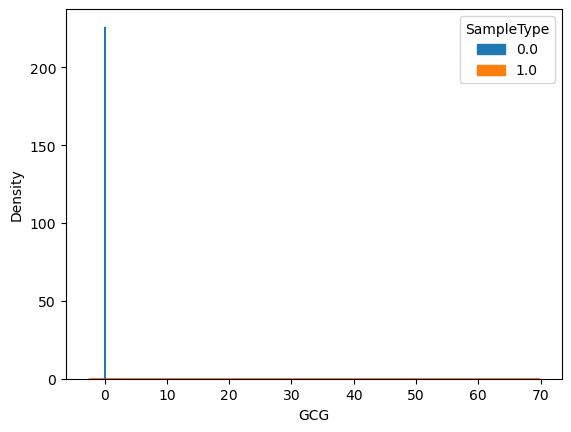

In [305]:
sns.kdeplot(data=df4, x='GCG', hue="SampleType", fill=True, common_norm=False, alpha=1)
plt.show()

Here it appears we have almost no activity for normal, but broad activity in the tumor type.  We will have to address the matter of low or no gene activity in normal samples.

In [306]:
grouped_raw = df4.groupby('SampleType')  #Here we see, for instance, ZYXP1 is not being expressed for either sample type.
print(grouped_raw.head()) 

0   SampleType      A1BG  ...  ZYXP1     ZZEF1
1          0.0  0.108403  ...    0.0  4.552543
2          0.0  0.095188  ...    0.0  5.626856
3          0.0  0.097043  ...    0.0  2.309259
4          0.0  0.043029  ...    0.0  5.302771
5          0.0  0.095016  ...    0.0  5.399341
50         1.0  0.064199  ...    0.0  1.506340
51         1.0  0.023191  ...    0.0  3.548103
52         1.0  0.039013  ...    0.0  1.999125
53         1.0  0.095058  ...    0.0  4.715684
54         1.0  0.024949  ...    0.0  4.604486

[10 rows x 56908 columns]


We should check on the total activity by sample type:  are there still genes with null expression?

In [307]:
gene_activity = grouped_raw.sum()
pd.options.display.max_columns = 5
print(gene_activity)

0                A1BG    A1BG-AS1  ...     ZYXP1        ZZEF1
SampleType                         ...                       
0.0          4.399017   46.155635  ...  0.000000   242.497597
1.0         53.455919  415.002253  ...  1.730455  1570.635163

[2 rows x 56907 columns]


Apparently so. 

## Normalization discussion and treatment of zeroes in the dataset

It is clear now that a high number of genes are not active in normal cell types.  Because we want to perform further operations like log, we have to deal with this situation.

There is an important decision to be made in terms of the approach:

One approach would be to simply discard or ignore genes with zero expression in normal tissue.  There are many potential reasons for doing so; one, for instance, is that some of the genes active in cancerous samples may have nothing to do with cancer, but rather, reflect other biological processes that may not be active in healthy patients (e.g. inflammatory response or other immune-related modulations). In other words, we don't want to select genes that would give a positive result when they are active for other reasons entirely---and then get false positives, where normal patients with a respiratory infection get labeled as possibly having cancer!  (The issue of false positives and false negatives will be of enormous importance in evaluating the performance of the model).

The second, more neutral approach is to add a tiny number, say, .000001 to all the expression data.  It won't do much at all to shift the mean and certainly doesn't harm standard deviation, and may be better than throwing away the zero data points so early on in the analysis.  (This is what most differential sequencing algorithms do anyway).

For now, we will proceed with the second approach, but revisit the decision as needed.

In [308]:
df5 = df4.add(1e-6)
logdf = np.log2(df5) 
print(logdf.head())

0  SampleType      A1BG  ...      ZYXP1     ZZEF1
1  -19.931569 -3.205504  ... -19.931569  2.186673
2  -19.931569 -3.393063  ... -19.931569  2.492329
3  -19.931569 -3.365224  ... -19.931569  1.207431
4  -19.931569 -4.538526  ... -19.931569  2.406747
5  -19.931569 -3.395667  ... -19.931569  2.432784

[5 rows x 56908 columns]


In [309]:
logdf['SampleType']=df4['SampleType'] #here we made sure sample type was ok.
print(logdf.head())

0  SampleType      A1BG  ...      ZYXP1     ZZEF1
1         0.0 -3.205504  ... -19.931569  2.186673
2         0.0 -3.393063  ... -19.931569  2.492329
3         0.0 -3.365224  ... -19.931569  1.207431
4         0.0 -4.538526  ... -19.931569  2.406747
5         0.0 -3.395667  ... -19.931569  2.432784

[5 rows x 56908 columns]


Now to proceed with grouping and taking mean and std:

In [310]:
grouped = logdf.groupby('SampleType')
avg_exp = grouped.mean()
pd.options.display.max_columns = 5
print(avg_exp)

0               A1BG  A1BG-AS1  ...      ZYXP1     ZZEF1
SampleType                      ...                     
0.0        -3.678356 -0.181150  ... -19.931569  2.251051
1.0        -3.750148 -0.658819  ... -19.890288  1.508643

[2 rows x 56907 columns]


In [311]:
std_exp = grouped.std()
pd.options.display.max_columns = 5
print(std_exp)

0               A1BG  A1BG-AS1  ...   ZYXP1     ZZEF1
SampleType                      ...                  
0.0         0.817152  0.534636  ...  0.0000  0.432589
1.0         1.582747  1.106743  ...  0.9249  0.667813

[2 rows x 56907 columns]


In [312]:
exp_stats = pd.concat([avg_exp, std_exp], axis=0)   #there might be more elegant ways to do this, but this worked easily
pd.options.display.max_columns = 5
print(exp_stats)

0               A1BG  A1BG-AS1  ...      ZYXP1     ZZEF1
SampleType                      ...                     
0.0        -3.678356 -0.181150  ... -19.931569  2.251051
1.0        -3.750148 -0.658819  ... -19.890288  1.508643
0.0         0.817152  0.534636  ...   0.000000  0.432589
1.0         1.582747  1.106743  ...   0.924900  0.667813

[4 rows x 56907 columns]


In [313]:
#Now I'd like to transpose and then compare and sort based on std
finaldf = exp_stats.T
print(finaldf.head())

SampleType        0.0        1.0       0.0       1.0
0                                                   
A1BG        -3.678356  -3.750148  0.817152  1.582747
A1BG-AS1    -0.181150  -0.658819  0.534636  1.106743
A1CF       -12.826603 -11.492063  5.785683  5.886855
A2M          9.506983   5.746430  0.559679  1.281895
A2M-AS1     -0.314353  -0.910212  0.416750  0.937864


In [314]:
finaldf.shape  #just checking

(56907, 4)

In [315]:
#Let's rename columns now...
new_col_names = ['Norm_mean', 'Tumor_mean', 'Norm_std','Tumor_std']
finaldf.columns = new_col_names
print(finaldf.head())

          Norm_mean  Tumor_mean  Norm_std  Tumor_std
0                                                   
A1BG      -3.678356   -3.750148  0.817152   1.582747
A1BG-AS1  -0.181150   -0.658819  0.534636   1.106743
A1CF     -12.826603  -11.492063  5.785683   5.886855
A2M        9.506983    5.746430  0.559679   1.281895
A2M-AS1   -0.314353   -0.910212  0.416750   0.937864


In [316]:
#and reset the index:
finaldf=finaldf.reset_index()
print(finaldf.head())

          0  Norm_mean  Tumor_mean  Norm_std  Tumor_std
0      A1BG  -3.678356   -3.750148  0.817152   1.582747
1  A1BG-AS1  -0.181150   -0.658819  0.534636   1.106743
2      A1CF -12.826603  -11.492063  5.785683   5.886855
3       A2M   9.506983    5.746430  0.559679   1.281895
4   A2M-AS1  -0.314353   -0.910212  0.416750   0.937864


In [317]:
#now, fix that new first column and call it NAME
new_col_names = ['NAME', 'Norm_mean', 'Tumor_mean', 'Norm_std','Tumor_std']
finaldf.columns=new_col_names
print(finaldf.head())

       NAME  Norm_mean  Tumor_mean  Norm_std  Tumor_std
0      A1BG  -3.678356   -3.750148  0.817152   1.582747
1  A1BG-AS1  -0.181150   -0.658819  0.534636   1.106743
2      A1CF -12.826603  -11.492063  5.785683   5.886855
3       A2M   9.506983    5.746430  0.559679   1.281895
4   A2M-AS1  -0.314353   -0.910212  0.416750   0.937864


### Summary:  we now have two new dataframes that will be useful as we proceed.
1) finaldf:  this dataframe contains the mean and standard deviation for each gene, grouped by sample type.
2) logdf:  this dataframe contains the log of expression values, for which 1e-6 was added to avoid zero mean values

All genes are included in these two dataframes.

### Calculating ratios, filtering and sorting

At this point I'd like to take the ratio of STDs (tumor/normal) and get a sorted list of genes: per the literature, we expect to see a marked difference in standard deviation between normal and cancerous genes.  What are we seeing?  (Incidentally, we can't use these ratios to select genes or to incorporate into the model--this is being done as a sanity check on our hypotheses above).

In [318]:
finaldf['stdratio'] = finaldf['Tumor_std']/finaldf['Norm_std']

In [319]:
print(finaldf.head(20))

           NAME  Norm_mean  ...  Tumor_std  stdratio
0          A1BG  -3.678356  ...   1.582747  1.936906
1      A1BG-AS1  -0.181150  ...   1.106743  2.070087
2          A1CF -12.826603  ...   5.886855  1.017487
3           A2M   9.506983  ...   1.281895  2.290412
4       A2M-AS1  -0.314353  ...   0.937864  2.250421
5         A2ML1  -5.701023  ...   3.281357  1.018108
6     A2ML1-AS1 -17.154222  ...   7.158587  1.208757
7     A2ML1-AS2 -18.986202  ...   4.942538  1.320596
8         A2MP1  -3.503619  ...   3.405242  3.940431
9       A3GALT2  -5.213303  ...   7.039031  2.155943
10       A4GALT   2.903878  ...   1.354900  2.298174
11        A4GNT  -4.067244  ...   6.174987  1.750156
12         AAAS   2.712468  ...   0.456013  1.796454
13         AACS   0.744734  ...   0.657045  2.544588
14       AACSP1  -5.748758  ...   5.869836  1.493969
15        AADAC   2.132542  ...   2.821134  2.182188
16      AADACL2  -9.618874  ...   5.941547  0.885836
17  AADACL2-AS1  -6.144172  ...   5.981093  0.

## Biological reasons for narrowing down our feature search

In [320]:
finaldf.sort_values(by=['stdratio'], ascending=False).nlargest(15,'stdratio')

,NAME,Norm_mean,...,Tumor_std,stdratio
13246,AL031584.1,-19.931569,...,2.239269,inf
44269,RN7SKP267,-19.931569,...,3.898363,inf
44282,RN7SKP28,-19.931569,...,4.132280,inf
44281,RN7SKP279,-19.931569,...,1.514959,inf
44280,RN7SKP278,-19.931569,...,0.823488,inf
44279,RN7SKP277,-19.931569,...,4.126881,inf
44273,RN7SKP270,-19.931569,...,1.053577,inf
9618,AC105081.1,-19.931569,...,3.503421,inf
44272,RN7SKP27,-19.931569,...,1.523444,inf
44268,RN7SKP266,-19.931569,...,3.803292,inf


We will fix the 'inf' values seen in this table in the next few steps.

As noted earlier some genes aren't being expressed in normal, healthy patient samples.

That said, many sequences in this array database are not genes, per se.  For instance, some of the above (anything with MIR as a prefix) are micro-rnas, which don't code for proteins directly, but are involved in regulating gene expression.  I am inclined to remove these from consideration.  Others, like RNArSP332, are pseudogenes (a nonfunctional segment that looks like a functional gene but can't code for a protein).  Still others, like RF00322, are small nucleolar RNAs and are involved in regulation of transcription factors.  Ultimately, rather than analyze all these, the goal will be to eliminate all but the genes coding for proteins.  In Section 2 we will further filter candidate genes based on annotations of their function (where known or predicted).

In [321]:
filtered_final = finaldf[finaldf['Norm_std'] > 1e-6]  #adding a tiny value to avoid NANs later
filtered_final.sort_values(by=['stdratio'], ascending=False).nlargest(50,'stdratio')

,NAME,Norm_mean,...,Tumor_std,stdratio
39821,PGM5P4,0.501840,...,7.792972,14.249742
46064,RNU5B-4P,0.449240,...,8.969577,12.597440
14319,AL136452.1,1.328496,...,8.283594,12.526865
39820,PGM5P3-AS1,-2.623688,...,7.273343,12.189945
39822,PGM5P4-AS1,-2.306742,...,7.446278,11.753980
13008,AL008733.1,-0.548366,...,8.332124,11.667950
27111,GLOD5,0.021836,...,5.129703,11.483851
27080,GKN2,4.736892,...,6.978927,11.264977
12715,AF186192.1,-1.183763,...,7.107154,11.247891
13731,AL109741.3,-0.741398,...,7.162730,11.117462


In [322]:
filtered_final.shape

(49604, 6)

### Summary

Now it is clear that a lot of genes weren't being expressed in the normal samples (about 7000 or so).  These were filtered out indirectly: we could have removed genes for which Norm_mean was zero, but those genes would also have a standard deviation of zero.  Either way, they are no longer included in the analysis.

## Informing feature selection

Most oncogenes are NOT specific to a particular cancer, and because it is so important to know if a tumor is primary or secondary, the search for truly unique oncogenes that are only expressed in one, or a handful of related cancer types, is very useful.  Certain oncogenes may thus be rejected for use in the final model, due to lack of specificity, but we will analyze this more in depth after we have added annotations.

As noted earlier there are more non-coding transcripts to be excluded as well.  For instance:

Certain LincRNAs are upregulated in 13 cancers--above we see a number of them strongly upregulated.  See also 'The functions and unique features of long intergenic non-coding RNA'
Julia D. Ransohoff,1 Yuning Wei,1 and Paul A. Khavari1,2  in Nat Rev Mol Cell Biol. Author manuscript; available in PMC 2018 Apr 6.
Published in final edited form as:
Nat Rev Mol Cell Biol. 2018 Mar; 19(3): 143–157.
Published online 2017 Nov 15. doi: 10.1038/nrm.2017.104

## Conclusions:  LUSC dataset wrangling

At first glance we can see some strong differences in expression variance between normal and tumor genes; that said, we have some 57000 genes in the dataset, and while we have gene names, we don't have functions.  Adding gene function information is essential in understanding what may be actually significant versus random noise.  Recall that, by conservative estimates, 51.8% of the human genome is transcribed, but only 1.2% encodes proteins!  As a path forward, while it is interesting to note what is going on with LINCrnas and other non-protein coding RNAs, it will be essential from an analysis standpoint to narrow the array data to protein-coding genes that are active in healthy lung tissue samples.

In the next section we add gene annotations, and attempt to downselect to roughly 25 genes *based entirely on biological considerations for normal activity*, that is, we will strenuously avoid using direct knowledge of tumor data as we choose candidate genes. The model will use these to predict tumor vs normal.  (We can also compare performance with sets of *known* oncogenes or biomarkers of disease as predictors).


## 2. Data wrangling, continued: Adding gene annotations to narrow down feature selection

Now we will use annotations of human genes from the following source: https://www.alliancegenome.org/downloads#gene-descriptions
which was found through this article: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7304461/ on automated gene annotation.

The file will need to be parsed and then matched to existing genes in the expression database.  The high level goal is to select a relatively small number of human genes--preferably related to healthy lung cell function--so that the use of expression data is properly limited to prevent overfitting, and hopefully, to improve the explainability of the model.  The compressed file was downloaded and unzipped to the working directory. 

In [323]:
import os
current_path = os.getcwd()
print(current_path)

os.listdir()

C:\Users\Owner\Downloads\archive (3)


['.ipynb_checkpoints',
 'GENE-DESCRIPTION-JSON_HUMAN.json',
 'GENE-DESCRIPTION-TSV_HUMAN.tsv',
 'GENE-DES_HUMAN.txt',
 'LUSCexpfile.csv',
 'LUSC_TLK_DW_EDA.ipynb']

To read a TSV (Tab-Separated Values) file into a pandas DataFrame, you can use the pd.read_csv() function with the sep parameter set to ‘\t’ to specify that the file is tab-separated:

In [324]:
#let's try it.
Annot_df = pd.read_csv('GENE-DESCRIPTION-TSV_HUMAN.tsv', skiprows=14, sep='\t', names =['CODE', 'NAME', 'DESCRIPTION'])
print(Annot_df.head())

         CODE   NAME                                        DESCRIPTION
0    HGNC:100  ASIC1  Enables pH-gated monoatomic ion channel activi...
1  HGNC:10000   RGS4  Predicted to enable GTPase activator activity;...
2  HGNC:10001   RGS5  Predicted to enable GTPase activator activity ...
3  HGNC:10002   RGS6  Enables GTPase activator activity. Predicted t...
4  HGNC:10003   RGS7  Enables G-protein alpha-subunit binding activi...


In [325]:
#what have we here...
Annot_df.shape

(43404, 3)

The goal now is to pull only those rows where the description includes the word 'Lung'.  Note that there are genes for which there is 'no description available'.  Those, perhaps, can be examined separately, if time permits.

In [326]:
filtered_df = Annot_df[Annot_df["DESCRIPTION"].str.contains("lung")]
print(filtered_df.head())

           CODE   NAME                                        DESCRIPTION
263   HGNC:1033   BDNF  Predicted to enable growth factor activity and...
375  HGNC:10451   RRM1  Enables identical protein binding activity and...
376  HGNC:10452   RRM2  Predicted to enable ribonucleoside-diphosphate...
390  HGNC:10471  RUNX1  Enables several functions, including DNA-bindi...
391  HGNC:10472  RUNX2  Enables sequence-specific double-stranded DNA ...


In [327]:
filtered_df.shape

(425, 3)

Excellent!  The total number of genes is much more manageable now, and we can filter further.

We will proceed by matching with the 'finaldf' which may contain genes with zero expression in normal samples--this is a note of caution.

In [328]:
print(finaldf.head())

       NAME  Norm_mean  ...  Tumor_std  stdratio
0      A1BG  -3.678356  ...   1.582747  1.936906
1  A1BG-AS1  -0.181150  ...   1.106743  2.070087
2      A1CF -12.826603  ...   5.886855  1.017487
3       A2M   9.506983  ...   1.281895  2.290412
4   A2M-AS1  -0.314353  ...   0.937864  2.250421

[5 rows x 6 columns]


In [329]:
merged_df = pd.merge(finaldf, filtered_df, on='NAME', how='right') 
print(merged_df.head())

    NAME  Norm_mean  ...        CODE                                        DESCRIPTION
0   BDNF  -0.078699  ...   HGNC:1033  Predicted to enable growth factor activity and...
1   RRM1   3.111166  ...  HGNC:10451  Enables identical protein binding activity and...
2   RRM2  -0.078324  ...  HGNC:10452  Predicted to enable ribonucleoside-diphosphate...
3  RUNX1   2.695032  ...  HGNC:10471  Enables several functions, including DNA-bindi...
4  RUNX2  -0.255691  ...  HGNC:10472  Enables sequence-specific double-stranded DNA ...

[5 rows x 8 columns]


In [330]:
merged_df.shape

(425, 8)

All of the genes matched.  Perhaps some are inactive in the normal tissue.  We can filter as before to check:

In [331]:
filtered_merged = merged_df[merged_df['Norm_std'] > 1e-6]  
filtered_merged.shape

(406, 8)

Ok:  19 genes off the list.  At this point we have gone through several iterations of the dataframe, and it is worth summarizing what we have.

### Summary of current dataframes:

filtered_merged:  This dataframe contains ONLY lung genes with non-zero expression in normal tissue, plus annotations and summary statistics.
logdf:  this dataframe contains the log expression values (with 1e-6 added), which will be needed in our analysis.

### More filtering:
We don't want to include KNOWN biomarkers of disease, so let's remove those from consideration: 

In [332]:
possible_targets = filtered_merged[~filtered_merged["DESCRIPTION"].str.contains("Biomarker")]
print(possible_targets.head(50))

           NAME  Norm_mean  ...        CODE                                        DESCRIPTION
18         SDHC   2.252911  ...  HGNC:10682  Predicted to enable heme binding activity. Pre...
27        SHOX2  -5.147524  ...  HGNC:10854  Predicted to enable DNA-binding transcription ...
28         SIM2  -2.986670  ...  HGNC:10883  Predicted to enable DNA-binding transcription ...
50      SULT1A1   2.343635  ...  HGNC:11453  Enables 3'-phosphoadenosine 5'-phosphosulfate ...
51         TBX4   3.392331  ...  HGNC:11603  Predicted to enable DNA-binding transcription ...
52        DAGLA   0.729317  ...   HGNC:1165  Predicted to enable lipoprotein lipase activit...
65        TRPC4  -1.367478  ...  HGNC:12336  Enables beta-catenin binding activity; cadheri...
74         ZIC3 -16.524010  ...  HGNC:12874  Enables DNA-binding transcription activator ac...
75       ZNF157  -4.162069  ...  HGNC:12942  Predicted to enable DNA-binding transcription ...
89       CHRNA9  -6.707083  ...  HGNC:14079  Enabl

In [333]:
possible_targets.shape

(58, 8)

Ok now we are down to 58 candidate genes.  Let's remove the known genes where the description includes 'Enables'.

The reason for this step is two-fold.  First, we'd like to get the number of variables down to roughly 25; secondly, we'd like to avoid using known genes (in the hopes that some biomarker discovery is a useful byproduct of the analysis).

In [334]:
final_targets = possible_targets[~possible_targets["DESCRIPTION"].str.contains("Enables")]
print(final_targets.head(50))

           NAME  Norm_mean  ...        CODE                                        DESCRIPTION
18         SDHC   2.252911  ...  HGNC:10682  Predicted to enable heme binding activity. Pre...
27        SHOX2  -5.147524  ...  HGNC:10854  Predicted to enable DNA-binding transcription ...
28         SIM2  -2.986670  ...  HGNC:10883  Predicted to enable DNA-binding transcription ...
51         TBX4   3.392331  ...  HGNC:11603  Predicted to enable DNA-binding transcription ...
52        DAGLA   0.729317  ...   HGNC:1165  Predicted to enable lipoprotein lipase activit...
75       ZNF157  -4.162069  ...  HGNC:12942  Predicted to enable DNA-binding transcription ...
91          CIC   3.277328  ...  HGNC:14214  Predicted to enable DNA-binding transcription ...
136     NKIRAS2   2.731888  ...  HGNC:17898  Predicted to enable GTPase activating protein ...
137     NKIRAS1   1.523857  ...  HGNC:17899  Predicted to enable GTPase activating protein ...
140       ASXL1   3.033214  ...  HGNC:18318  Predi

In [335]:
#Looking a lot better.  That said, consider row 190: 'Implicated in lung cancer'. We should apply another filter:
final_targets2 = final_targets[~final_targets["DESCRIPTION"].str.contains("cancer")]
print(final_targets2.head(50))

        NAME  Norm_mean  ...        CODE                                        DESCRIPTION
18      SDHC   2.252911  ...  HGNC:10682  Predicted to enable heme binding activity. Pre...
28      SIM2  -2.986670  ...  HGNC:10883  Predicted to enable DNA-binding transcription ...
51      TBX4   3.392331  ...  HGNC:11603  Predicted to enable DNA-binding transcription ...
75    ZNF157  -4.162069  ...  HGNC:12942  Predicted to enable DNA-binding transcription ...
91       CIC   3.277328  ...  HGNC:14214  Predicted to enable DNA-binding transcription ...
136  NKIRAS2   2.731888  ...  HGNC:17898  Predicted to enable GTPase activating protein ...
137  NKIRAS1   1.523857  ...  HGNC:17899  Predicted to enable GTPase activating protein ...
140    ASXL1   3.033214  ...  HGNC:18318  Predicted to enable several functions, includi...
147    DPPA2 -17.706303  ...  HGNC:19197  Predicted to enable chromatin binding activity...
148    DPPA4  -7.029122  ...  HGNC:19200  Predicted to enable chromatin binding 

Now the dataset is approaching a small enough number to work with.  The other seven genes can be held out for now, and added back later if needed.

In [336]:
final_targets3 = final_targets[final_targets["DESCRIPTION"].str.contains("cancer")]
print(final_targets3.head(50))

           NAME  Norm_mean  ...        CODE                                        DESCRIPTION
27        SHOX2  -5.147524  ...  HGNC:10854  Predicted to enable DNA-binding transcription ...
52        DAGLA   0.729317  ...   HGNC:1165  Predicted to enable lipoprotein lipase activit...
157       TRPC7 -18.928888  ...  HGNC:20754  Predicted to enable inositol 1,4,5 trisphospha...
190     CCDC116  -3.821066  ...  HGNC:26688  Located in centrosome. Implicated in lung cancer.
193       MPZL3   2.652505  ...  HGNC:27279  Predicted to be involved in cell adhesion. Pre...
271  MIRLET7BHG  -1.572545  ...  HGNC:37189  Predicted to be involved in miRNA-mediated pos...
407     PPP2R1B   2.077881  ...   HGNC:9303  Predicted to enable protein phosphatase regula...

[7 rows x 8 columns]


## Finalizing predictor gene sets

After merging the gene expression data with gene annotations, and filtering to include only genes active in normal lung tissue, removing those known to be biomarkers of disease, and separating those already implicated in cancer, we arrived at two datasets.
The first contains 24 genes with some predicted functions; the second set contains 7 which are implicated in lung cancer.  We will use the second set as needed if the performance of the first set is weak.

Another note of caution on the gene set we have now.  Many of them are predicted to play some role in carcinomas:

In [337]:
slim_final=final_targets2[~final_targets2["DESCRIPTION"].str.contains("carcinoma")]
print(slim_final.head())

        NAME  Norm_mean  ...        CODE                                        DESCRIPTION
28      SIM2  -2.986670  ...  HGNC:10883  Predicted to enable DNA-binding transcription ...
51      TBX4   3.392331  ...  HGNC:11603  Predicted to enable DNA-binding transcription ...
75    ZNF157  -4.162069  ...  HGNC:12942  Predicted to enable DNA-binding transcription ...
91       CIC   3.277328  ...  HGNC:14214  Predicted to enable DNA-binding transcription ...
136  NKIRAS2   2.731888  ...  HGNC:17898  Predicted to enable GTPase activating protein ...

[5 rows x 8 columns]


Again, this is something we may return to later. As an aside, MPZL3 is involved in cell adhesion--we speculate its role could be akin to a virulence factor, where (mal)expression of that gene leads to poor cell adherence and thus metastatic cancer.  And finally--one more look at what the annotations are telling us:

In [338]:
other_targets = possible_targets[possible_targets["DESCRIPTION"].str.contains("carcinoma")]  #how many of these have 'carcinoma' in them
print(other_targets.head(50))

       NAME  Norm_mean  ...        CODE                                        DESCRIPTION
18     SDHC   2.252911  ...  HGNC:10682  Predicted to enable heme binding activity. Pre...
89   CHRNA9  -6.707083  ...  HGNC:14079  Enables acetylcholine-gated monoatomic cation-...
105   RTEL1  -2.851685  ...  HGNC:15888  Enables ATP binding activity and DNA helicase ...
139   CMPK1   5.360355  ...  HGNC:18170  Enables UMP kinase activity and nucleoside dip...
158    PAOX   1.126756  ...  HGNC:20837  Enables polyamine oxidase activity. Involved i...
208   STRAP   5.229397  ...  HGNC:30796  Enables RNA binding activity. Involved in main...
243  SNHG20   0.124062  ...  HGNC:33099  Predicted to be involved in cellular response ...
263     FES   3.069147  ...   HGNC:3657  Enables immunoglobulin receptor binding activi...
268      FH   4.173180  ...   HGNC:3700  Enables fumarate hydratase activity and histon...
306  HS3ST2   1.973635  ...   HGNC:5195  Enables [heparan sulfate]-glucosamine 3-sulfot...

## Section 2 Summary and Conclusion

We will now proceed to analyze 'final_targets2' which contains the genes matching the following filtering criteria:
--active in normal lung tissue
--genes with potential for bio marker discovery (that is, not known biomarkers of cancer or other disease, though some may be suspected to play a role in cancer or carcinomas)
--genes with predicted functions (not unknown, but also not definitively characterized).

We also have additional 'short lists'  and variations of the key set, above, which may be experimented on as we explore models later.

At this stage we have a small enough set of target genes to proceed with EDA, preprocessing, and model building.

(Finally, we note that a great many other avenues were explored, and later rejected: the above search for candidate genes is the best found so far).

# 3. EDA with candidate gene sets 

Earlier we looked at a few random genes and compared the normal vs cancer expression levels.  It would be good to do the same with the candidate genes from section 2.

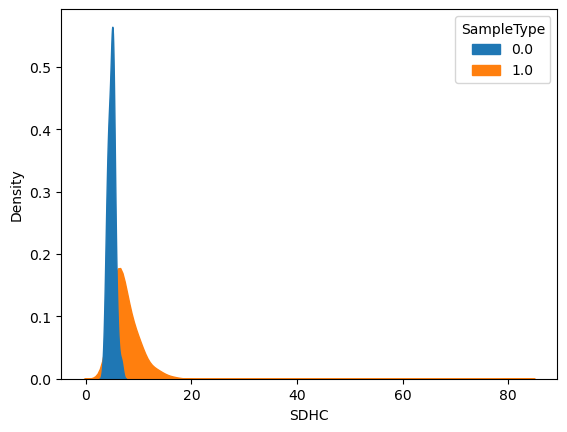

In [339]:
sns.kdeplot(data=df4, x='SDHC', hue="SampleType", fill=True, common_norm=False, alpha=1)  #just using the prior df4 dataframe
plt.show()

TBD: let's plot or list the std_ratios and mean expression differences/normal gene std.

In [340]:
#create list of candidate genes from earlier.
Gene_list = list(final_targets2['NAME'])  #I only want the names for now
print(Gene_list)

['SDHC', 'SIM2', 'TBX4', 'ZNF157', 'CIC', 'NKIRAS2', 'NKIRAS1', 'ASXL1', 'DPPA2', 'DPPA4', 'STK40', 'COPA', 'TMEM38B', 'CCDC40', 'MIR367', 'SNHG20', 'ATXN1L', 'CFC1B', 'FENDRR', 'LAMA3', 'MAN1A2', 'MAN2A1', 'MSH5', 'NAT2']


OK:  next we perform a sanity check to see what the candidate genes might be doing in normal vs tumor tissue
We have to be careful that Norm_delta does not enter the picture later in the model.  It is only for exploration.

The variable 'Norm-Delta' is the difference in mean expression for each gene between normal and tumor tissue.  In the model, we anticipate using the ratio of expression level to the NORMAL tissue type standard deviation.

In [341]:
#Next do a calculation for ALL genes, since our target list may vary
finaldf['Norm_delta'] = (finaldf['Tumor_mean'] - finaldf['Norm_mean'])/finaldf['Norm_std']
pd.set_option('display.max_columns', 1000) #now I want to see the columns more clearly
pd.set_option('display.width', 1000)
print(finaldf.head())

       NAME  Norm_mean  Tumor_mean  Norm_std  Tumor_std  stdratio  Norm_delta
0      A1BG  -3.678356   -3.750148  0.817152   1.582747  1.936906   -0.087856
1  A1BG-AS1  -0.181150   -0.658819  0.534636   1.106743  2.070087   -0.893447
2      A1CF -12.826603  -11.492063  5.785683   5.886855  1.017487    0.230663
3       A2M   9.506983    5.746430  0.559679   1.281895  2.290412   -6.719130
4   A2M-AS1  -0.314353   -0.910212  0.416750   0.937864  2.250421   -1.429774


## A brief interlude for more data wrangling before proceeding with EDA:

I want a simpler dataframe to work with, that's easier to read, etc, for analysis.  I'm going to construct an EDA dataframe, which is based on the gene list of final targets, above.

In [342]:
#ok, let's see if this helps. 
mask = finaldf['NAME'].isin(Gene_list)
EDA_data = finaldf[mask]

print(EDA_data.head(30))

          NAME  Norm_mean  Tumor_mean  Norm_std  Tumor_std  stdratio  Norm_delta
19392    ASXL1   3.033214    2.965735  0.331737   0.568385  1.713361   -0.203412
19631   ATXN1L   2.987904    2.577886  0.395435   0.585538  1.480744   -1.036879
21338   CCDC40  -0.174904   -1.459606  1.190263   1.151161  0.967149   -1.079344
22022    CFC1B -18.581555  -19.570268  4.052522   2.221798  0.548251   -0.243975
22222      CIC   3.277328    3.462740  0.442868   0.785067  1.772689    0.418660
22668     COPA   5.114477    5.545745  0.219132   0.442652  2.020019    1.968067
24278    DPPA2 -17.706303   -9.603190  5.095698   8.993804  1.764980    1.590187
24287    DPPA4  -7.029122   -7.972699  4.061045   4.782399  1.177628   -0.232348
26087   FENDRR   2.784248   -1.935167  0.890335   1.820095  2.044281   -5.300719
30921    LAMA3   3.410678    3.201375  0.699877   1.656641  2.367046   -0.299058
33596   MAN1A2   2.360571    2.624083  0.347194   0.590257  1.700078    0.758974
33601   MAN2A1   1.996711   

### Important wrangling step before we proceed:  clean up the indices in some of the dataframes from earlier

In [343]:
#Ok I will now set the index to NAME in 'finaldf' so I can pull out genes more easily
finaldf.set_index('NAME', inplace=True)
print(finaldf.head())

          Norm_mean  Tumor_mean  Norm_std  Tumor_std  stdratio  Norm_delta
NAME                                                                      
A1BG      -3.678356   -3.750148  0.817152   1.582747  1.936906   -0.087856
A1BG-AS1  -0.181150   -0.658819  0.534636   1.106743  2.070087   -0.893447
A1CF     -12.826603  -11.492063  5.785683   5.886855  1.017487    0.230663
A2M        9.506983    5.746430  0.559679   1.281895  2.290412   -6.719130
A2M-AS1   -0.314353   -0.910212  0.416750   0.937864  2.250421   -1.429774


In [344]:
#let's do that with the annotations too...
final_targets2.set_index('NAME', inplace = True)
print(final_targets2.head())

        Norm_mean  Tumor_mean  Norm_std  Tumor_std  stdratio        CODE                                        DESCRIPTION
NAME                                                                                                                       
SDHC     2.252911    2.826615  0.198894   0.459122  2.308381  HGNC:10682  Predicted to enable heme binding activity. Pre...
SIM2    -2.986670   -0.474648  0.483191   1.707957  3.534748  HGNC:10883  Predicted to enable DNA-binding transcription ...
TBX4     3.392331   -0.254923  0.705874   1.553770  2.201200  HGNC:11603  Predicted to enable DNA-binding transcription ...
ZNF157  -4.162069   -4.498144  2.581526   4.081157  1.580909  HGNC:12942  Predicted to enable DNA-binding transcription ...
CIC      3.277328    3.462740  0.442868   0.785067  1.772689  HGNC:14214  Predicted to enable DNA-binding transcription ...


In [345]:
#now once more:
EDA_data.set_index('NAME', inplace=True)

print(EDA_data.head())

        Norm_mean  Tumor_mean  Norm_std  Tumor_std  stdratio  Norm_delta
NAME                                                                    
ASXL1    3.033214    2.965735  0.331737   0.568385  1.713361   -0.203412
ATXN1L   2.987904    2.577886  0.395435   0.585538  1.480744   -1.036879
CCDC40  -0.174904   -1.459606  1.190263   1.151161  0.967149   -1.079344
CFC1B  -18.581555  -19.570268  4.052522   2.221798  0.548251   -0.243975
CIC      3.277328    3.462740  0.442868   0.785067  1.772689    0.418660


In [346]:
print(final_targets2.loc['TBX4'].values) 

[3.392331231466092 -0.2549229077671009 0.7058737641016737
 1.5537696752684174 2.2012004897870283 'HGNC:11603'
 'Predicted to enable DNA-binding transcription factor activity, RNA polymerase II-specific and RNA polymerase II cis-regulatory region sequence-specific DNA binding activity. Involved in embryonic hindlimb morphogenesis; embryonic lung development; and skeletal system morphogenesis. Predicted to be part of chromatin. Predicted to be active in nucleus. Implicated in arthropathy and ischiocoxopodopatellar syndrome.']


## Returning to EDA

In [347]:
#I want to see the ranked list of targets:
print(EDA_data.sort_values(by=['Norm_delta'], ascending=False).nlargest(20,'Norm_delta'))

         Norm_mean  Tumor_mean  Norm_std  Tumor_std  stdratio  Norm_delta
NAME                                                                     
SIM2     -2.986670   -0.474648  0.483191   1.707957  3.534748    5.198822
NKIRAS2   2.731888    3.524384  0.200198   0.458122  2.288342    3.958553
SDHC      2.252911    2.826615  0.198894   0.459122  2.308381    2.884476
COPA      5.114477    5.545745  0.219132   0.442652  2.020019    1.968067
TMEM38B   1.197102    2.058172  0.500399   1.024133  2.046632    1.720764
SNHG20    0.124062    1.054194  0.579025   0.915609  1.581294    1.606377
DPPA2   -17.706303   -9.603190  5.095698   8.993804  1.764980    1.590187
MSH5     -2.524527   -1.087734  1.105124   1.227619  1.110843    1.300119
MAN1A2    2.360571    2.624083  0.347194   0.590257  1.700078    0.758974
CIC       3.277328    3.462740  0.442868   0.785067  1.772689    0.418660
MAN2A1    1.996711    2.043456  0.343070   0.649092  1.892011    0.136256
MIR367  -18.432784  -18.957262  5.0862

In [348]:
#ok, this is useful; 4 genes have 2stds difference or more, 11 have at least 1 std difference.  I wonder what SIM2 is doing:
print(final_targets2.loc['SIM2'].values) 

[-2.986669521076872 -0.47464785040660773 0.4831905783460199
 1.7079571152546102 3.5347483825140253 'HGNC:10883'
 'Predicted to enable DNA-binding transcription factor activity, RNA polymerase II-specific and RNA polymerase II transcription regulatory region sequence-specific DNA binding activity. Predicted to be involved in regulation of transcription by RNA polymerase II. Predicted to act upstream of or within embryonic pattern specification; lung development; and negative regulation of transcription by RNA polymerase II. Located in nuclear body.']


It looks like we are on the right track; I'd like to look ata plot of the ranked absolute value of this ratio next.

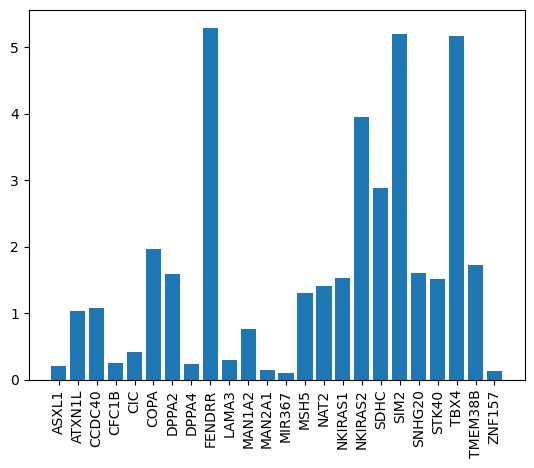

In [349]:
abs_ND = EDA_data['Norm_delta'].abs()  #Here we are comparing absolute values for easier visualization
Names = list(EDA_data.index)
plt.bar(Names, abs_ND)
plt.xticks(rotation='vertical')
plt.show()

Now we can see that many of these genes do look rather suspicious, with mean expression in tumor tissue many standard deviations out of line with the normal tissue expression levels.  In particular, FENDRR, SIM2 and TBX4 seem dramatically different in their behavior.  

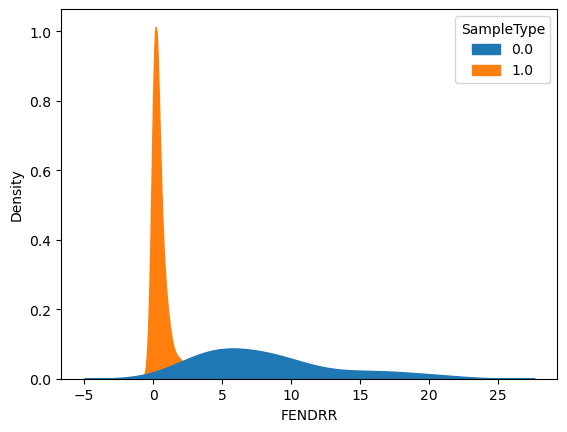

In [350]:
sns.kdeplot(data=df4, x='FENDRR', hue="SampleType", fill=True, common_norm=False, alpha=1)  #just using the prior df4 dataframe
plt.show()

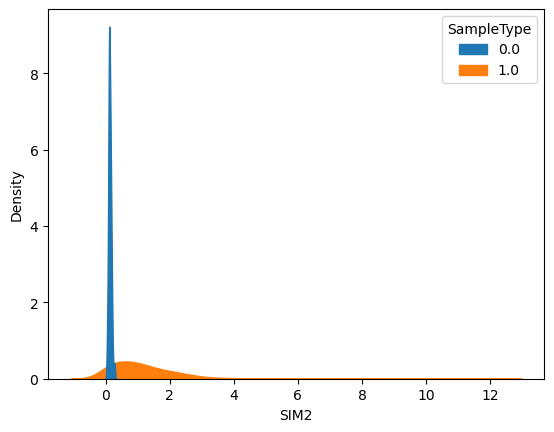

In [351]:
sns.kdeplot(data=df4, x='SIM2', hue="SampleType", fill=True, common_norm=False, alpha=1)  #just using the prior df4 dataframe
plt.show()

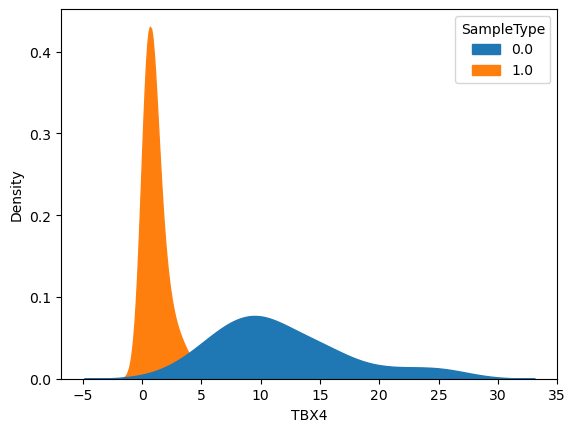

In [352]:
sns.kdeplot(data=df4, x='TBX4', hue="SampleType", fill=True, common_norm=False, alpha=1)  #just using the prior df4 dataframe
plt.show()

# Summary:  Data Wrangling and EDA

Thus far we have narrowed down our candidate gene set based on biological considerations using the annotations, and have shown that our hypothesis (that expression levels between normal and tumor tissue should differ markedly) appears to be true for most of the genes in our candidate set.  Next we will proceed with pre-processing and model development.  We may choose to add or remove some genes, but for now, will proceed with what we have found in 'final_targets2' for model development.  

Note that for the above gene set, some of the genes are suppressed in tumor tissue; TBX4, for instance (recall that '0' is normal, and '1' is tumor. SIM2 is being activated in tumors, whereas TBX4 and FENDRR are being suppressed.  We expected to see up- and down-regulation of genes for the different tissue types.

Entering this list of genes in the gene ontology resource (https://geneontology.org/) gives a number of key biological processes these genes are involved in:

1) MutSgamma complex	A heterodimer involved in the stabilization of DNA recombination intermediates, the promotion of crossover recombination, and the proper assembly of the synaptonemal complex in meiotic prophase nuclei. 

2) 	PR-DUB complex	A multimeric protein complex that removes monoubiquitin from histone H2A. In Drosophila and mammals, the core of the complex is composed of Calypso/BAP1 and Asx/ASXL1, respectively. 

3) 	Polycomb repressive deubiquitinase complex		7-dehydrocholesterol reductase activity	Catalysis of the reaction: cholesterol + NADP+ = 7-dehydrocholesterol + H+ + NADyy
 
4) 
	inferior colliculus developme.nt	The process whose specific outcome is the progression of the inferior colliculus over time, from its formation to the mature structure. The inferior colliculus (IC) (Latin, lower hill) is the principal midbrain nucleus of the auditory pathway and receives input from several more peripheral brainstem nuclei in the auditory pathway, as well as inputs from the auditory ctex.

The last is a curious find, to say the least.ss

# 4. Preprocessing

First we need to construct the analysis dataframe, which should contain: gene name, log expression level/norm_std, label (0=normal, 1=tumor).  The ratio of log expression level/norm std is the variable we will model on.  

That said:  we have to be careful to avoid data leakage.  So in fact, we have to follow our steps in a different order.  We have to do the train/test first, and then use only X_train to develop the standard deviation of expression for each gene in the set.  We then have to calculate X_train_norm and X_test_norm.  This approach prevents any mixing of training and test data.

Finally, we have to do a stratified split because of the class imbalance.

The desired final dataframe should have 551 rows; with 24 columns determined by the downselected Gene_list.

Start with logdf and do a stratified split:

In [480]:
pd.options.display.max_columns = 5
print(logdf.head())

0  SampleType      A1BG  ...      ZYXP1     ZZEF1
1         0.0 -3.205504  ... -19.931569  2.186673
2         0.0 -3.393063  ... -19.931569  2.492329
3         0.0 -3.365224  ... -19.931569  1.207431
4         0.0 -4.538526  ... -19.931569  2.406747
5         0.0 -3.395667  ... -19.931569  2.432784

[5 rows x 56908 columns]


In [481]:
X = logdf[Gene_list]   #at any time in the future we can modify the list and then update below.
y = logdf['SampleType']  #this wouldn't have to be modified

In [482]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify = y, random_state=4)

In [483]:
X_train.shape   #Checking the outcome of the split--looks good

(369, 24)

In [484]:
print(y_train.sum())  #336 tumor out of 369, so, 33 normals...I guess this is ok then, 16 left in the test set.

336.0


## Procedure

In the next few lines, I will mask out the tumor rows and take standard deviation for X_train.  Then, I will convert that series into a dataframe, concatenate with the original X_train so that the last row contains the normal standard deviations.  Finally, I will divide each column by that final value--and at last we will be ready to model!  (Well, I will drop the last row with the stds, just to keep things clean, too).

In [485]:
mask = y_train == 0  #want to use the mask (true values) to calculate STD on X_train

In [486]:
X_std = X_train[mask][Gene_list].std()  #ok, now we have the standard deviations for the normal tissue, training set only
print(X_std)

0
SDHC       0.199427
SIM2       0.520479
TBX4       0.726051
ZNF157     1.016902
CIC        0.499404
NKIRAS2    0.215393
NKIRAS1    0.312395
ASXL1      0.313064
DPPA2      5.687924
DPPA4      4.329418
STK40      0.349309
COPA       0.233343
TMEM38B    0.583302
CCDC40     1.205920
MIR367     4.346785
SNHG20     0.576038
ATXN1L     0.390425
CFC1B      3.986311
FENDRR     0.807655
LAMA3      0.757120
MAN1A2     0.344491
MAN2A1     0.365254
MSH5       1.121157
NAT2       3.110032
dtype: float64


In [503]:
new_row = pd.DataFrame(X_std)
print(new_row.T)

0      SDHC      SIM2  ...      MSH5      NAT2
0  0.199427  0.520479  ...  1.121157  3.110032

[1 rows x 24 columns]


In [528]:
X_nm = pd.concat([X_train, new_row.T]) 
print(X_nm.tail())  

0        SDHC      SIM2  ...      MSH5       NAT2
318  2.393629  1.247791  ... -0.410492  -2.002321
58   3.813081 -0.788389  ... -2.249729  -5.656084
526  3.169623 -0.473980  ... -0.664562  -1.620603
360  2.651125  1.076419  ...  0.847728 -19.931569
0    0.199427  0.520479  ...  1.121157   3.110032

[5 rows x 24 columns]


In [522]:
print(X_train.tail())  #for comparison.  Ok, so these look fine.

0        SDHC      SIM2  ...      MSH5       NAT2
166  2.576747 -0.274803  ... -1.333553 -19.931569
318  2.393629  1.247791  ... -0.410492  -2.002321
58   3.813081 -0.788389  ... -2.249729  -5.656084
526  3.169623 -0.473980  ... -0.664562  -1.620603
360  2.651125  1.076419  ...  0.847728 -19.931569

[5 rows x 24 columns]


## Final steps

We now have the standard deviation of the normal samples only tacked on at the end of each column (which you can see at the bottom of X_nm, but not present in the original X_train).  Last thing to do is to divide all the values in each column by that final value.  We'll do this first with X_train, then repeat the process with X_test.

If need be these steps can be put into a custom function in case the Gene_list varies a lot (which I don't anticipate, but may happen).

In [523]:
X_nm.shape  #I want to use indexing, somehow, to reference the last row

(370, 24)

In [529]:
X_normed = X_nm.div(X_nm.iloc[369])   #ok, this worked.
print(X_normed)   

0         SDHC      SIM2  ...      MSH5      NAT2
245  11.601709 -2.680649  ... -2.086565 -0.706452
34   12.051121 -5.805099  ... -2.677834 -0.661282
506  14.099356  2.234560  ... -0.690303 -1.821754
412  13.707076  0.533881  ...  0.249583 -6.408798
247  13.509179 -1.297056  ...  0.120554 -6.408798
..         ...       ...  ...       ...       ...
318  12.002559  2.397388  ... -0.366132 -0.643827
58   19.120222 -1.514737  ... -2.006613 -1.818657
526  15.893682 -0.910660  ... -0.592746 -0.521089
360  13.293738  2.068131  ...  0.756118 -6.408798
0     1.000000  1.000000  ...  1.000000  1.000000

[370 rows x 24 columns]


In [533]:
X_normed.drop(X_normed.tail(1).index,
        inplace = True)

In [535]:
X_normed.shape

(369, 24)

Now let's do the same for X_test: add the final row with the *training sample* standard dev, divide, and drop final row:

In [536]:
X_nt = pd.concat([X_test, new_row.T]) 
print(X_nt.tail())  

0        SDHC      SIM2  ...      MSH5      NAT2
87   3.261726 -1.128819  ... -2.854613 -4.261016
161  2.560663  1.641049  ... -0.329908 -2.888322
73   3.354530 -3.398621  ...  1.196603 -2.565953
441  2.995755 -0.599680  ... -1.579006 -1.525995
0    0.199427  0.520479  ...  1.121157  3.110032

[5 rows x 24 columns]


In [538]:
X_nt.shape

(183, 24)

In [540]:
X_ntest = X_nt.div(X_nt.iloc[182])   #division step 

0         SDHC       SIM2  ...      MSH5      NAT2
65   12.740609  -4.220879  ... -0.249490 -6.408798
493  19.485544  -6.070189  ... -3.274365 -6.408798
215  12.591481 -10.227481  ... -2.082261 -1.134099
365  14.209131   2.937429  ...  1.204665 -6.408798
191  17.124452   2.645187  ...  0.103073 -1.133343
..         ...        ...  ...       ...       ...
87   16.355524  -2.168807  ... -2.546130 -1.370087
161  12.840126   3.152957  ... -0.294256 -0.928711
73   16.820876  -6.529792  ...  1.067293 -0.825057
441  15.021844  -1.152168  ... -1.408371 -0.490668
0     1.000000   1.000000  ...  1.000000  1.000000

[183 rows x 24 columns]


In [541]:
X_ntest.drop(X_ntest.tail(1).index,
        inplace = True)
print(X_ntest.tail())

0         SDHC      SIM2  ...      MSH5      NAT2
327  14.366838  0.204589  ... -0.912384 -1.911644
87   16.355524 -2.168807  ... -2.546130 -1.370087
161  12.840126  3.152957  ... -0.294256 -0.928711
73   16.820876 -6.529792  ...  1.067293 -0.825057
441  15.021844 -1.152168  ... -1.408371 -0.490668

[5 rows x 24 columns]


## Summary--preprocessing

We now have our train/test split, properly stratified, with the data normalized using only the X_train normal standard deviation values.  This process took a lot more work than usual, even though there weren't any categorical variables to deal with.  We couldn't really use Standard Scaler, and had to be careful to avoid data leakage.  Now we are ready to model.  (As mentioned earlier, we may automate these steps if need be).

Going forward, we use X_normed in place of X_train, and X_ntest in place of X_test. y_train, y_test stay the same.

# 5. Model development

Ideally, it would be great to divide the dataset into three, with a training set, a development set, and a test set, but we have to work with what we've got.  For now I've chosen a one third split (above) between training/test; it's not really optimal to do tuning on the training set, but here we are.

### 5.1 Logistic regression

In [424]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [542]:
classifier = LogisticRegression(solver = 'liblinear', max_iter = 500, C=1000)
classifier.fit(X_normed, y_train)
print(f'Accuracy on training data: {accuracy_score(classifier.predict(X_normed), y_train):.2f}')

Accuracy on training data: 1.00


In [543]:
print(f'Accuracy on test data: {accuracy_score(classifier.predict(X_ntest), y_test):.2f}')

Accuracy on test data: 0.96


Let's go a little further with this:

In [544]:
print("Classification Report for Test Data")
print(classification_report(y_test, classifier.predict(X_ntest)))

Classification Report for Test Data
              precision    recall  f1-score   support

         0.0       0.70      0.88      0.78        16
         1.0       0.99      0.96      0.98       166

    accuracy                           0.96       182
   macro avg       0.84      0.92      0.88       182
weighted avg       0.96      0.96      0.96       182



Aha, well it's not perfect; it's great at finding the tumor tissue, but sometimes misses normal tissue.  Not really surprising with a small numer of normal samples overall.

In [545]:
y_pred = classifier.predict(X_ntest)  #let's keep this handy

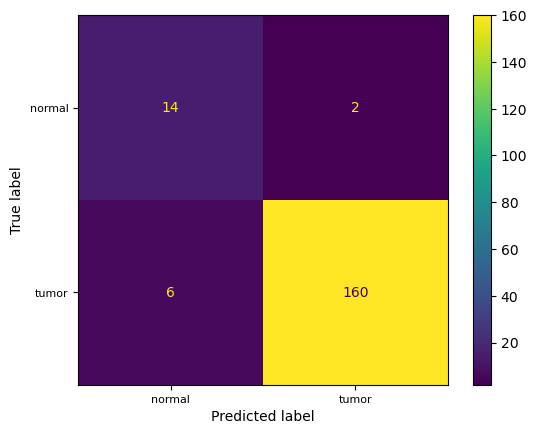

In [546]:
cm = confusion_matrix(y_test, y_pred)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['normal', 'tumor'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['normal', 'tumor'], fontsize = 8)
ax.set_yticklabels(labels = ['normal', 'tumor'], fontsize = 8)
display_cm.plot(ax = ax)

This looks like a good start.  Perhaps we should tune the model next.

In [547]:
feature_importances= classifier.coef_[0]
feature_df = pd.DataFrame({'Feature': X_normed.columns, 'Importance': feature_importances})
feature_df = feature_df.sort_values('Importance', ascending=False)
print(feature_df)

    Feature  Importance
13   CCDC40    5.202279
12  TMEM38B    4.931180
4       CIC    2.930689
22     MSH5    2.868202
0      SDHC    2.844702
1      SIM2    2.780806
23     NAT2    1.302780
3    ZNF157    1.093700
10    STK40    0.995118
5   NKIRAS2    0.781099
15   SNHG20    0.585136
19    LAMA3    0.029760
7     ASXL1   -0.173980
9     DPPA4   -0.214109
20   MAN1A2   -0.841604
8     DPPA2   -1.016413
21   MAN2A1   -1.032632
2      TBX4   -1.099089
16   ATXN1L   -1.483904
11     COPA   -1.610834
14   MIR367   -1.684682
17    CFC1B   -3.569829
6   NKIRAS1   -3.616764
18   FENDRR   -5.074418


### 5.1a Bio-break and sanity checks

The rankings above are a little different from the ratios calculated during EDA, but that's ok.  Let's re-examine the annotations.

In [549]:
print(final_targets2.loc['CCDC40'].values) 

[-0.1749035458787888 -1.4596063653576157 1.1902630504126877
 1.1511613929206603 0.9671487260917072 'HGNC:26090'
 'Involved in axonemal dynein complex assembly; determination of left/right symmetry; and lung development. Acts upstream of or within cilium assembly; flagellated sperm motility; and regulation of cilium beat frequency. Located in axoneme. Implicated in primary ciliary dyskinesia 15.']


Primary ciliary dyskinesia is a rare inherited disorder which can result in lung infections, as the cilia work to clear lung airways of debris and pathogens. Because it is rare, it makes sense to keep this gene in the set; moreover, ciliary dyskinesia could be secondary to lung cell squamous cell cancer.

In [551]:
print(final_targets2.loc['TMEM38B'].values) 

[1.1971022776499096 2.058171532561923 0.5003994895325917
 1.0241334876539683 2.046631759378054 'HGNC:25535'
 'Predicted to enable potassium channel activity. Predicted to be involved in potassium ion transmembrane transport. Predicted to act upstream of or within several processes, including cellular response to caffeine; lung development; and regulation of cardiac muscle contraction by regulation of the release of sequestered calcium ion. Located in nucleus. Implicated in osteogenesis imperfecta type 14.']


Well, these are critically important cellular functions. (And where would we be without caffeine?)

In [552]:
print(final_targets2.loc['CIC'].values) 

[3.2773284396076114 3.4627395306176756 0.4428677767693778
 0.7850667951850839 1.7726889070863816 'HGNC:14214'
 'Predicted to enable DNA-binding transcription factor activity, RNA polymerase II-specific and RNA polymerase II transcription regulatory region sequence-specific DNA binding activity. Predicted to be involved in several processes, including learning or memory; regulation of DNA-templated transcription; and social behavior. Predicted to act upstream of or within lung alveolus development and negative regulation of transcription by RNA polymerase II. Located in nucleoplasm. Implicated in autosomal dominant intellectual developmental disorder 45.']


Here there is some overlap in activity with unrelated tissue types...hold for now.

In [562]:
print(final_targets2.loc['MSH5'].values) 

[-2.5245268269426258 -1.087734060892827 1.105123881891961
 1.2276194200847326 1.110843263999562 'HGNC:7328'
 'Predicted to enable double-stranded DNA binding activity. Predicted to be involved in chiasma assembly. Predicted to act upstream of or within female gamete generation and homologous chromosome pairing at meiosis. Predicted to be located in synaptonemal complex. Predicted to be active in nucleus. Implicated in lung non-small cell carcinoma; primary ovarian insufficiency 13; and spermatogenic failure.']


While I see non-specific activity here, I don't see any other overlap with lung cancer, so for now, I'll keep it.

In [563]:
print(final_targets2.loc['SDHC'].values) 

[2.252910856105114 2.8266147078194517 0.19889362401392296
 0.4591223035740862 2.308381205532997 'HGNC:10682'
 'Predicted to enable heme binding activity. Predicted to be involved in mitochondrial electron transport, succinate to ubiquinone. Predicted to be located in mitochondrial inner membrane. Implicated in Carney-Stratakis syndrome; gastrointestinal stromal tumor; lung non-small cell carcinoma; and paraganglioma.']


Now here we have a gene which isn't really specific to lung cell cancer, so it should be removed. UGH!

In [564]:
print(final_targets2.loc['SIM2'].values) 

[-2.986669521076872 -0.47464785040660773 0.4831905783460199
 1.7079571152546102 3.5347483825140253 'HGNC:10883'
 'Predicted to enable DNA-binding transcription factor activity, RNA polymerase II-specific and RNA polymerase II transcription regulatory region sequence-specific DNA binding activity. Predicted to be involved in regulation of transcription by RNA polymerase II. Predicted to act upstream of or within embryonic pattern specification; lung development; and negative regulation of transcription by RNA polymerase II. Located in nuclear body.']


We can keep this.

In [565]:
print(final_targets2.loc['NAT2'].values) 

[-3.5064566188472863 -7.168036605992753 2.5924634602425956
 6.5262022450223425 2.51737482325465 'HGNC:7646'
 'Predicted to enable arylamine N-acetyltransferase activity. Predicted to be involved in xenobiotic metabolic process. Predicted to be located in cytosol. Implicated in several diseases, including autoimmune disease (multiple); carcinoma (multiple); contact dermatitis (multiple); leukemia (multiple); and lung disease (multiple).']


Sigh, this one has to go as well.  Non-specific!

In [566]:
print(final_targets2.loc['ZNF157'].values) 

[-4.1620687928804685 -4.498144228723901 2.5815260044626465
 4.081157220446414 1.580908816487371 'HGNC:12942'
 'Predicted to enable DNA-binding transcription factor activity, RNA polymerase II-specific and RNA polymerase II cis-regulatory region sequence-specific DNA binding activity. Predicted to be involved in regulation of transcription by RNA polymerase II. Predicted to act upstream of or within lung alveolus development; mammary gland morphogenesis; and regulation of cell fate commitment. Predicted to be active in nucleus.']


Ok, we can keep it.

In [568]:
print(final_targets2.loc['STK40'].values) 

[4.13905014284157 3.567808999861877 0.376918388281853 0.6476989889298946
 1.7184064483623884 'HGNC:21373'
 'Predicted to enable ATP binding activity; protein serine kinase activity; and protein serine/threonine kinase activity. Predicted to act upstream of or within several processes, including glycogen metabolic process; lung development; and respiratory system process. Located in cytosol and nucleoplasm.']


No problems here.

In [569]:
print(final_targets2.loc['NKIRAS2'].values) 

[2.7318883428877307 3.524383966880439 0.2001982980391666 0.458122262453363
 2.2883424431697037 'HGNC:17898'
 'Predicted to enable GTPase activating protein binding activity. Predicted to be involved in Ral protein signal transduction. Predicted to act upstream of or within several processes, including lung alveolus development; regulation of signal transduction; and surfactant homeostasis. Predicted to be located in cytoplasm.']


No problems with this either.

In [570]:
print(final_targets2.loc['SNHG20'].values) 

[0.12406179755237405 1.0541939117011958 0.5790247749533721
 0.9156086097345812 1.5812943579284904 'HGNC:33099'
 'Predicted to be involved in cellular response to fatty acid; gene expression; and macrophage activation. Implicated in lung non-small cell carcinoma.']


'Implicated' is ok, especially when it's specific to what we're looking for.

In [567]:
print(final_targets2.loc['LAMA3'].values) 

[3.410678313299039 3.2013748326449836 0.6998769899690653
 1.6566408814547224 2.367045788329098 'HGNC:6483'
 'Predicted to enable integrin binding activity. Predicted to be an extracellular matrix structural constituent. Involved in endodermal cell differentiation. Located in endoplasmic reticulum. Implicated in junctional epidermolysis bullosa and lung small cell carcinoma.']


*Implicated* in the kind of carcinoma we are interested in, but unfortunately, it's of low predictive value. (JEB is a rare inherited disorder, no worries on that).

In [571]:
print(final_targets2.loc['ASXL1'].values) 

[3.0332137997143658 2.965734542664676 0.3317370866336717
 0.5683853393518026 1.713360857899663 'HGNC:18318'
 'Predicted to enable several functions, including nuclear retinoic acid receptor binding activity; peroxisome proliferator activated receptor binding activity; and transcription coactivator activity. Predicted to be involved in several processes, including negative regulation of fat cell differentiation; regulation of intracellular signal transduction; and response to retinoic acid. Predicted to act upstream of or within several processes, including heart morphogenesis; hematopoietic or lymphoid organ development; and lung saccule development. Part of PR-DUB complex. Implicated in SM-AHNMD; acute myeloid leukemia; chronic myelomonocytic leukemia; myelodysplastic syndrome; and myelofibrosis.']


Sadly we probably have to take this one, because it's implicated in other cancers.

In [572]:
print(final_targets2.loc['DPPA4'].values) 

[-7.02912236276202 -7.972699237922327 4.061044989809652 4.782398944938433
 1.177627668971624 'HGNC:19200'
 'Predicted to enable chromatin binding activity. Predicted to be involved in system development. Predicted to act upstream of or within lung-associated mesenchyme development. Predicted to be located in nucleoplasm. Predicted to be active in nucleus.']


No problem.

In [573]:
print(final_targets2.loc['MAN1A2'].values) 

[2.3605713765398217 2.6240825650401507 0.34719382047861014
 0.5902565814246187 1.7000780158210884 'HGNC:6822'
 'Predicted to enable mannosyl-oligosaccharide 1,2-alpha-mannosidase activity. Predicted to be involved in N-glycan processing. Predicted to act upstream of or within glycoprotein metabolic process; lung alveolus development; and respiratory gaseous exchange by respiratory system. Located in Golgi apparatus.']


Np, next gene please.

In [574]:
print(final_targets2.loc['DPPA2'].values) 

[-17.706303259074456 -9.603190418372876 5.095698347110564
 8.993803515755367 1.7649795775009254 'HGNC:19197'
 'Predicted to enable chromatin binding activity. Predicted to be involved in system development. Predicted to act upstream of or within several processes, including epigenetic regulation of gene expression; lung-associated mesenchyme development; and positive regulation of stem cell proliferation. Located in nucleoplasm.']


Np, moving on:

In [575]:
print(final_targets2.loc['MAN2A1'].values) 

[1.9967106850086804 2.0434560549969105 0.34307009621818924
 0.6490924696204945 1.892011215129861 'HGNC:6824'
 'Predicted to enable alpha-mannosidase activity. Predicted to be involved in N-glycan processing. Predicted to act upstream of or within several processes, including lung alveolus development; respiratory gaseous exchange by respiratory system; and retina morphogenesis in camera-type eye. Located in Golgi medial cisterna.']


On we go.  The next one we saw before, no red flags.

In [576]:
print(final_targets2.loc['TBX4'].values) 

[3.392331231466092 -0.2549229077671009 0.7058737641016737
 1.5537696752684174 2.2012004897870283 'HGNC:11603'
 'Predicted to enable DNA-binding transcription factor activity, RNA polymerase II-specific and RNA polymerase II cis-regulatory region sequence-specific DNA binding activity. Involved in embryonic hindlimb morphogenesis; embryonic lung development; and skeletal system morphogenesis. Predicted to be part of chromatin. Predicted to be active in nucleus. Implicated in arthropathy and ischiocoxopodopatellar syndrome.']


In [577]:
print(final_targets2.loc['ATXN1L'].values)

[2.987904241806709 2.57788629075195 0.3954347983586936 0.5855377767511339
 1.48074418129484 'HGNC:33279'
 'Predicted to enable DNA binding activity; POZ domain binding activity; and RNA binding activity. Predicted to be involved in learning or memory; regulation of DNA-templated transcription; and social behavior. Predicted to act upstream of or within several processes, including lung alveolus development; negative regulation of transcription by RNA polymerase II; and positive regulation of hematopoietic stem cell proliferation. Located in nucleolus and nucleoplasm.']


OK, next:

In [578]:
print(final_targets2.loc['COPA'].values)

[5.1144774726414335 5.5457447374090485 0.21913239326823997
 0.4426515470119326 2.0200187676957593 'HGNC:2230'
 'Predicted to enable mRNA binding activity. Acts upstream of or within pancreatic juice secretion. Located in cytoplasm; extracellular space; and growth cone. Part of COPI vesicle coat. Implicated in autoimmune interstitial lung, joint, and kidney disease.']


Probably safe to keep. 

In [579]:
print(final_targets2.loc['MIR367'].values)

[-18.432783957399508 -18.957261990591718 5.086234616734857
 4.09200219515555 0.8045248604324979 'HGNC:31781'
 'Predicted to be involved in miRNA-mediated post-transcriptional gene silencing. Predicted to act upstream of or within cellular response to leukemia inhibitory factor and lung development. Predicted to be part of RISC complex.']


Unfortunately this one has to go.

In [580]:
print(final_targets2.loc['CFC1B'].values)

[-18.581554857461917 -19.570268351157054 4.0525223395851535
 2.22179795497611 0.5482506372077273 'HGNC:33983'
 'Predicted to enable activin receptor binding activity and nodal binding activity. Predicted to be involved in circulatory system development; nodal signaling pathway; and regionalization. Predicted to act upstream of or within several processes, including heart development; left lung morphogenesis; and spleen development. Predicted to be active in cell surface and extracellular region. Implicated in tetralogy of Fallot and visceral heterotaxy.']


Tetralogy of Fallot and visceral heterotaxy are congenital heart defects; no need to discard this gene. 

In [581]:
print(final_targets2.loc['NKIRAS1'].values)

[1.5238570997549936 1.0912858600762692 0.28423190361179873
 0.4713036562265538 1.6581659209877295 'HGNC:17899'
 'Predicted to enable GTPase activating protein binding activity. Predicted to be involved in Ral protein signal transduction. Predicted to act upstream of or within lung alveolus development; regulation of tumor necrosis factor-mediated signaling pathway; and surfactant homeostasis. Located in cytosol and endoplasmic reticulum.']


This gene *may* have some involvement with tumors beyond LSSC, but can be kept for now.

In [582]:
print(final_targets2.loc['FENDRR'].values)

[2.784248295436026 -1.9351674930148044 0.8903350652149983
 1.8200946697472484 2.044280564539746 'HGNC:43894'
 'Predicted to enable core promoter sequence-specific DNA binding activity. Predicted to be involved in in utero embryonic development and lung development. Predicted to act upstream of or within several processes, including chromatin organization; embryonic lung development; and lateral mesoderm development.']


And that's ok.  In sum, we have to remove MIR367, ASXL1,SDHC, NAT2: we will do this in Model section 5.2.

## Cross-validation and tuning

Given such a small set of normal samples, were we just a little (un)lucky?  Let's see what the cross-validation says.

In [555]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(classifier, X_normed, y_train.values.ravel(), cv=5,scoring='f1_weighted')

print("%0.2f weighted f1 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.99 weighted f1 with a standard deviation of 0.01


Nice, but that reflects what's going on with the training set, which already had good performance stats.  Now let's see if we can improve the model by trying different optimization parameters.

In [556]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}
 
# Create GridSearchCV object
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_normed, y_train.values.ravel()) 

GridSearchCV(cv=5,
             estimator=LogisticRegression(C=1000, max_iter=500,
                                          solver='liblinear'),
             param_grid={'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='f1_weighted')

In [557]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Best Score: 0.997355348328672


In [558]:
best_classifier = LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.1, penalty='l2')
best_classifier.fit(X_normed, y_train.values.ravel())

print("Classification Report for Training Data")
print(classification_report(y_train, best_classifier.predict(X_normed)))

Classification Report for Training Data
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        33
         1.0       1.00      1.00      1.00       336

    accuracy                           1.00       369
   macro avg       0.99      1.00      0.99       369
weighted avg       1.00      1.00      1.00       369



And now for the acid test:

In [559]:
print("Classification Report for Test Data")
print(classification_report(y_test, best_classifier.predict(X_ntest)))

Classification Report for Test Data
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        16
         1.0       0.99      1.00      1.00       166

    accuracy                           0.99       182
   macro avg       1.00      0.97      0.98       182
weighted avg       0.99      0.99      0.99       182



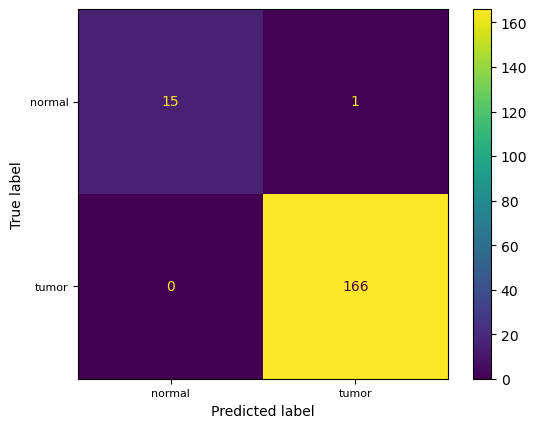

In [560]:
y_predict_test = best_classifier.predict(X_ntest)
y_predict_training = best_classifier.predict(X_normed)

cm = confusion_matrix(y_test, y_predict_test, labels = best_classifier.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['normal', 'tumor'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['normal', 'tumor'], fontsize = 8)
ax.set_yticklabels(labels = ['normal', 'tumor'], fontsize = 8)
display_cm.plot(ax = ax)

I don't want to celebrate too early, but this is pretty awesome.

### 5.2 Logistic regression with reduced gene list

After revisiting the annotations, we had to remove some genes because they are involved in other types of cancer, so while they may be of value in various ways, they could lead to non-specific results for the test envisioned in this project.  They are: MIR367, ASXL1,SDHC, NAT2.

5.2a. Revisit some pre-processing steps before trying LR's again. Start by finalizing the gene list, then doing train/test split:

In [583]:
print(Gene_list)

['SDHC', 'SIM2', 'TBX4', 'ZNF157', 'CIC', 'NKIRAS2', 'NKIRAS1', 'ASXL1', 'DPPA2', 'DPPA4', 'STK40', 'COPA', 'TMEM38B', 'CCDC40', 'MIR367', 'SNHG20', 'ATXN1L', 'CFC1B', 'FENDRR', 'LAMA3', 'MAN1A2', 'MAN2A1', 'MSH5', 'NAT2']


In [585]:
Final_GL = ['SIM2', 'TBX4', 'ZNF157', 'CIC', 'NKIRAS2', 'NKIRAS1', 'DPPA2', 'DPPA4', 'STK40', 'COPA', 'TMEM38B', 'CCDC40', 'SNHG20', 'ATXN1L', 'CFC1B', 'FENDRR', 'LAMA3', 'MAN1A2', 'MAN2A1', 'MSH5']


In [586]:
Z = logdf[Final_GL]  #y was previously defined, don't need to worry about it so much; calling it Z to preserve the prior work

In [595]:
Z_train, Z_test, y_train, y_test = train_test_split(
    Z, y, test_size=0.33, stratify = y, random_state=5)  #picking different random state for fun

In [596]:
mask2 = y_train == 0

In [599]:
Z_std = Z_train[mask2][Final_GL].std()  #ok, now we have the standard deviations for the normal tissue, training set only

In [600]:
final_row = pd.DataFrame(Z_std)
Z_nm = pd.concat([Z_train, final_row.T]) #here we just added the stdev values; getting ready to normalize 

In [601]:
Z_normed = Z_nm.div(Z_nm.iloc[369])   #This is the normalization step
print(Z_normed)   

0         SIM2      TBX4  ...    MAN2A1      MSH5
262 -13.384249  2.010706  ...  9.776032 -1.908293
1    -5.085989  4.444146  ...  4.856002 -2.217862
452  -0.144323  0.119280  ...  3.456150 -0.144364
65   -4.499673  0.085078  ...  7.448431 -0.252018
501   1.023704  1.341971  ...  4.250278  0.068870
..         ...       ...  ...       ...       ...
175   0.410282 -0.936338  ...  5.296035 -0.555915
308   1.531673  0.144944  ...  6.064249 -0.549359
166  -0.562853  1.578813  ...  4.354528 -1.201493
389   0.835484 -1.753021  ...  9.551744 -1.498073
0     1.000000  1.000000  ...  1.000000  1.000000

[370 rows x 20 columns]


In [602]:
Z_normed.drop(Z_normed.tail(1).index,
        inplace = True)            #here we drop the last row

Same procedure for Z_test (has to be normalized as before)

In [603]:
Z_nt = pd.concat([Z_test, final_row.T]) #easier because we have the standard deviations already
print(Z_nt.tail()) 

0        SIM2      TBX4  ...    MAN2A1      MSH5
85  -2.334781  2.714001  ...  2.629035 -0.196847
41  -3.166133  3.739298  ...  2.342303 -2.404796
414 -0.176185  2.107108  ...  2.309213 -0.487495
541  0.219694 -0.325261  ...  1.796813 -2.140507
0    0.488231  0.732544  ...  0.349771  1.109913

[5 rows x 20 columns]


In [604]:
Z_ntest = Z_nt.div(Z_nt.iloc[182]) #division step

In [605]:
Z_ntest.drop(Z_ntest.tail(1).index,
        inplace = True)
print(Z_ntest.tail())

0        SIM2      TBX4  ...    MAN2A1      MSH5
321  2.399707 -5.465592  ...  7.368727 -1.056767
85  -4.782122  3.704899  ...  7.516445 -0.177353
41  -6.484907  5.104538  ...  6.696674 -2.166652
414 -0.360864  2.876425  ...  6.602069 -0.439219
541  0.449979 -0.444016  ...  5.137112 -1.928535

[5 rows x 20 columns]


## 5.3  Logistic Regression model, take 2.

Now with the reduced gene set, I will use the model parameters for the previous model (may have to revisit that), and check performance.


In [606]:
classifier = LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.1, penalty='l2')
classifier.fit(Z_normed, y_train.values.ravel())

print("Classification Report for Training Data")
print(classification_report(y_train, classifier.predict(Z_normed)))

Classification Report for Training Data
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        33
         1.0       1.00      1.00      1.00       336

    accuracy                           1.00       369
   macro avg       1.00      1.00      1.00       369
weighted avg       1.00      1.00      1.00       369



Perfect on the training data?!?!  well, let's see about the test set.

In [607]:
print("Classification Report for Test Data")
print(classification_report(y_test, classifier.predict(Z_ntest)))

Classification Report for Test Data
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        16
         1.0       1.00      0.99      0.99       166

    accuracy                           0.99       182
   macro avg       0.94      0.99      0.97       182
weighted avg       0.99      0.99      0.99       182



Wow.  This is *without* some of the earlier genes.

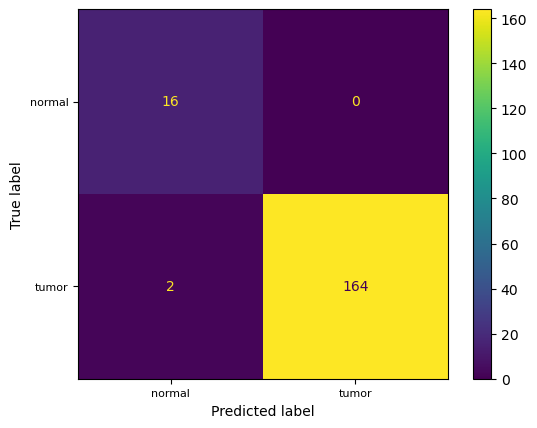

In [609]:
y_predict_test = classifier.predict(Z_ntest)
y_predict_training = classifier.predict(Z_normed)

cm = confusion_matrix(y_test, y_predict_test, labels = classifier.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['normal', 'tumor'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['normal', 'tumor'], fontsize = 8)
ax.set_yticklabels(labels = ['normal', 'tumor'], fontsize = 8)
display_cm.plot(ax = ax)

How did the predictive features rank this time?

In [610]:
feature_importances= classifier.coef_[0]
feature_df = pd.DataFrame({'Feature': Z_normed.columns, 'Importance': feature_importances})
feature_df = feature_df.sort_values('Importance', ascending=False)
print(feature_df)

    Feature  Importance
4   NKIRAS2    0.333256
0      SIM2    0.266043
9      COPA    0.168256
10  TMEM38B    0.163898
12   SNHG20    0.163257
6     DPPA2    0.161269
19     MSH5    0.112614
18   MAN2A1    0.075056
17   MAN1A2    0.065573
2    ZNF157    0.056477
7     DPPA4    0.047945
3       CIC    0.039763
14    CFC1B   -0.020209
16    LAMA3   -0.032361
11   CCDC40   -0.057153
13   ATXN1L   -0.192889
5   NKIRAS1   -0.228252
8     STK40   -0.273506
1      TBX4   -0.546827
15   FENDRR   -0.598319


# Summary and Conclusions

I honestly did not expect performance at this level.  Efforts were made to avoid overfit by further downselecting the gene set; the effort was justified after noting that four of the predictors were not specific for lung small cell cancer. The final list of genes ranked by feature importances is above.

The test exhibited a small (1/82) false negative rate, and a zero false-positive rate (where positive indicates tumor tissue).  So it may rarely miss a cancer case, but should not set of false alarms. 

It seems that using expression levels based on a small set of genes (normalized by standard deviation of normal tissue expression levels) provides very informative predictor genes.  One is tempted to see 'how low can we go' in terms of gradually reducing the predictor set; for future work I could automate the pre-processing and remove genes with the smallest absolute value of importance one at a time, and see how the test performs, but with microplate technology the number of predictors is already small enough to be economical.